# Ungraded Lab: Multiple LSTMs

<a target="_blank" href="https://colab.research.google.com/github/LuisAngelMendozaVelasco/TensorFlow_Developer_Professional_Certificate/blob/master/Natural_Language_Processing_in_TensorFlow/Week3/Labs/C3_W3_Lab_2_multiple_layer_LSTM.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png">Run in Google Colab</a>

In this lab, you will look at how to build a model with multiple LSTM layers. Since you know the preceding steps already (e.g. downloading datasets, preparing the data, etc.), we won't expound on it anymore so you can just focus on the model building code.

## Download and Prepare the Dataset

In [1]:
import tensorflow_datasets as tfds
import numpy as np
from keras import layers, Sequential, Input
import matplotlib.pyplot as plt
import seaborn as sns

2024-06-13 12:18:26.631713: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# Download the subword encoded pretokenized dataset
dataset, info = tfds.load('imdb_reviews/subwords8k', with_info=True, as_supervised=True)

# Get the tokenizer
tokenizer = info.features['text'].encoder

2024-06-13 12:18:29.043716: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1928] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 1637 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1650, pci bus id: 0000:01:00.0, compute capability: 7.5


Like the previous lab, we increased the `BATCH_SIZE` here to make the training faster. If you are doing this on your local machine and have a powerful processor, feel free to use the value used in the lecture (i.e. 64) to get the same results as Laurence.

In [3]:
BUFFER_SIZE = 10000
BATCH_SIZE = 32 # 256

# Get the train and test splits
train_data, test_data = dataset['train'], dataset['test'], 

# Shuffle the training data
train_dataset = train_data.shuffle(BUFFER_SIZE)

# Batch and pad the datasets to the maximum length of the sequences
train_dataset = train_dataset.padded_batch(BATCH_SIZE)
test_dataset = test_data.padded_batch(BATCH_SIZE)

## Build and Compile the Model

You can build multiple layer LSTM models by simply appending another `LSTM` layer in your `Sequential` model and enabling the `return_sequences` flag to `True`. This is because an `LSTM` layer expects a sequence input so if the previous layer is also an LSTM, then it should output a sequence as well. See the code cell below that demonstrates this flag in action. You'll notice that the output dimension is in 3 dimensions `(batch_size, timesteps, features)` when when `return_sequences` is True.

In [4]:
# Hyperparameters
batch_size = 1
timesteps = 20
features = 16
lstm_dim = 8

print(f'batch_size: {batch_size}')
print(f'timesteps (sequence length): {timesteps}')
print(f'features (embedding size): {features}')
print(f'lstm output units: {lstm_dim}')

# Define array input with random values
random_input = np.random.rand(batch_size,timesteps, features)
print(f'shape of input array: {random_input.shape}')

# Define LSTM that returns a single output
lstm = layers.LSTM(lstm_dim)
result = lstm(random_input)
print(f'shape of lstm output(return_sequences=False): {result.shape}')

# Define LSTM that returns a sequence
lstm_rs = layers.LSTM(lstm_dim, return_sequences=True)
result = lstm_rs(random_input)
print(f'shape of lstm output(return_sequences=True): {result.shape}')

batch_size: 1
timesteps (sequence length): 20
features (embedding size): 16
lstm output units: 8
shape of input array: (1, 20, 16)
shape of lstm output(return_sequences=False): (1, 8)
shape of lstm output(return_sequences=True): (1, 20, 8)


2024-06-13 12:18:29.689360: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8907


The next cell implements the stacked LSTM architecture.

In [5]:
# Hyperparameters
embedding_dim = 64
lstm1_dim = 64
lstm2_dim = 32
dense_dim = 64

# Build the model
model = Sequential([Input(shape=(None,)),
                    layers.Embedding(tokenizer.vocab_size, embedding_dim),
                    layers.Bidirectional(layers.LSTM(lstm1_dim, return_sequences=True)),
                    layers.Bidirectional(layers.LSTM(lstm2_dim)),
                    layers.Dense(dense_dim, activation='relu'),
                    layers.Dense(1, activation='sigmoid')])

# Print the model summary
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, None, 64)       │       523,840 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, None, 128)      │        66,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 64)             │        41,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 635,329 (2.42 MB)

 Trainable params: 635,329 (2.42 MB)

 Non-trainable params: 0 (0.00 B)

In [6]:
# Set the training parameters
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

## Train the Model

The additional LSTM layer will lengthen the training time compared to the previous lab. Given the default parameters we set, it will take around 2 minutes per epoch with the Colab GPU enabled. 

In [7]:
NUM_EPOCHS = 10

# Train the model
history = model.fit(train_dataset, epochs=NUM_EPOCHS, validation_data=test_dataset)

Epoch 1/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 152s 187ms/step - accuracy: 0.6511 - loss: 0.6189 - val_accuracy: 0.7907 - val_loss: 0.4834
Epoch 2/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 145s 185ms/step - accuracy: 0.6674 - loss: 0.5984 - val_accuracy: 0.7265 - val_loss: 0.5940
Epoch 3/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 145s 186ms/step - accuracy: 0.7970 - loss: 0.4535 - val_accuracy: 0.8312 - val_loss: 0.4062
Epoch 4/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 145s 185ms/step - accuracy: 0.8801 - loss: 0.3112 - val_accuracy: 0.8637 - val_loss: 0.3307
Epoch 5/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 140s 180ms/step - accuracy: 0.9186 - loss: 0.2160 - val_accuracy: 0.8624 - val_loss: 0.3365
Epoch 6/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 136s 174ms/step - accuracy: 0.9431 - loss: 0.1631 - val_accuracy: 0.8649 - val_loss: 0.3940
Epoch 7/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 136s 174ms/step - accuracy: 0.9647 - loss: 0.1077 - val_accuracy: 0.8560 - val_loss: 0.3747
Epoch 8/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 135s 173ms/step - accuracy: 0.9718 -

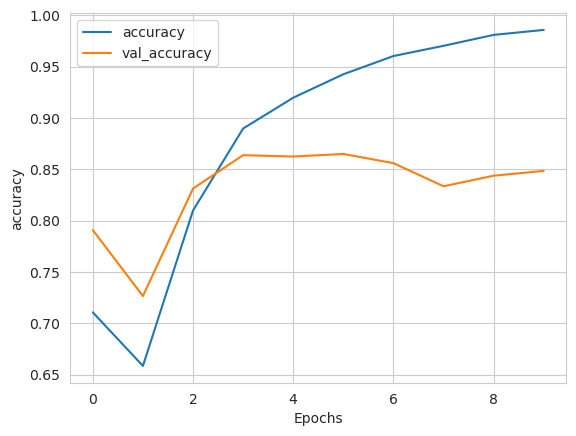

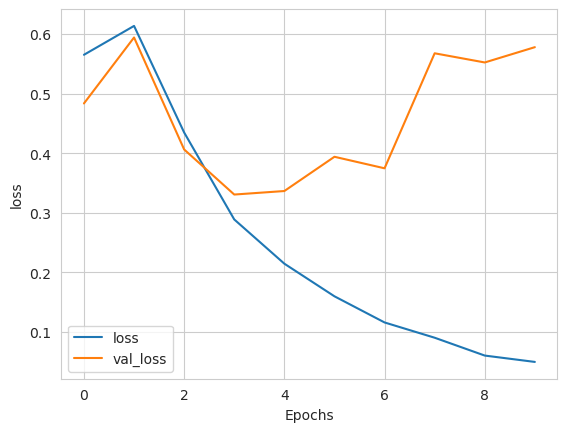

In [8]:
sns.set_style("whitegrid")

# Plot utility
def plot_graphs(history, string):
    plt.figure()
    plt.plot(history.history[string])
    plt.plot(history.history['val_' + string])
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, 'val_' + string])
    plt.show()

# Plot the accuracy and results 
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

## Wrap Up

This lab showed how you can build deep networks by stacking LSTM layers. In the next labs, you will continue exploring other architectures you can use to implement your sentiment classification model.